# PD 6 - Marcin Łukaszyk Grupa 2

In [1]:
using IJulia 
IJulia.installkernel("Julia nodeps")
IJulia.clear_output();

In [2]:
using Pkg
using DataFrames
using Plots
using Clustering
using CSV
using Statistics 
IJulia.clear_output();

In [3]:
data = CSV.read("C:\\Users\\lukas\\Desktop\\data.txt",header = ["x1","x2","x3"])
first(data,5)

,x1,x2,x3
,Float64,Float64,Float64
1,152.078,197.91,1.09571
2,145.52,202.128,2.73883
3,155.441,198.123,0.640457
4,150.389,206.808,0.686486
5,149.863,205.418,3.55581


Dane zostały wczytane poprawnie :)

# Metody wybrane do porównania

W tej pracy porównam algorytm MCL (Markov Cluster Algorithm) oraz algorytm heurestyczny.
Oba są zaimplementowane w pakiecie [Clustering.jl](https://github.com/JuliaStats/Clustering.jl).

### Algorytm MCL

Działanie algorytmu polega na losowych ścieżkach w ważonym krawędziowo grafie. 
Graf tworzymy na ze zbioru danych interpretując wierzchołki jak kolejne rekordy a wartości wag na krawędziach jako odległości między punktami.

### Algorytm Hierarchiczny

Działenie algorytmu polega na przypisaniu każdemu rekorodwi w danych osobnego klastra a następnie złącznie tych które są najbliżej siebie.
Końcowym stanem będzie jeden wielki klaster.
Można więc tworzyć drzewo i łączyć punkty na odpowiedniej wysokości dzrewa która implikowała by bliskość obu klastrów.

# Metryki Ocen Klasteryzacji

Do oceny jakości algorytmów użyje nastęujących metryk **:**
* Indeks Dunn'a
* Współczynnik Silhouette

Współczynnik Dunn'a jest ilorazem minimalnej odległości między klastrami oraz maksymalnej odległości w którymkolwiek z klastrów.

Współczynnik Silhouette jest wartością przypisywaną **każdemu** punktowi ze zbioru. 
Określa on jak podobny jest wybrany punkt do przypisanego mu klastra i jak inny jest od punktów w obcych klastrach. 

In [4]:
function dunn_index(d,a,og)
    k = maximum(a)
    if(k<2)
        return 0
    end
    n = size(a)[1]
    centers = zeros(k,4)
    max_d = 0
    min_d = Inf
    for ind=1:n
        centers[a[ind],1] += og[ind,1]
        centers[a[ind],2] += og[ind,2]
        centers[a[ind],3] += og[ind,3]
        centers[a[ind],4] += 1
    end
    for ind=1:k
        centers[ind,1] = centers[ind,1]/centers[ind,4]
        centers[ind,2] = centers[ind,2]/centers[ind,4]
        centers[ind,3] = centers[ind,3]/centers[ind,4]
    end
    for i=1:k
        for j=1:k
            if(max_d<√((centers[i,1]-centers[j,1])^2 + (centers[i,2]-centers[j,2])^2 + (centers[i,3]-centers[j,3])^2))
                max_d = √((centers[i,1]-centers[j,1])^2 + (centers[i,2]-centers[j,2])^2 + (centers[i,3]-centers[j,3])^2)
            end
        end
    end
    for i=1:k
        for j=1:n
            if(a[j]==i)
                for u = 1:n
                    if(d[j,u]<min_d)
                        min_d = d[j,u]
                    end
                end
            end
                
        end
    end
    return(min_d/max_d)
end

dunn_index (generic function with 1 method)

Do wyznaczenia indeksu Dunn'a stworzyłem własną funkcje.
Współczynnik Silhouette można wyliczyć korzystając z funkcji silhouettes() z pakietu Clustering.jl

# Macierz Odległości  

W obu implementacjach algorytmów potrzebujemy macierzy odległośći. 

In [5]:
n = size(data)[1]
d_mat = zeros(n,n)
for i=1:n
    for j=1:n
        d_mat[i,j] = √((data[i,1] - data[j,1])^2 + (data[i,2] - data[j,2])^2 + (data[i,3] - data[j,3])^2)
    end
end

# Algorytm MCL

In [67]:
d_mar = mcl(d_mat,expansion = 2,inflation = 2,add_loops = true);

In [68]:
println("Ilość Klastrów : ",maximum(d_mar.assignments))
println("Indeks Dunn'a : ",dunn_index(d_mat,d_mar.assignments,data))
print("Współczynnik Silhouette : ",mean(silhouettes(d_mar.assignments,d_mat)))

Ilość Klastrów : 2
Indeks Dunn'a : 0.0009806564486071329
Współczynnik Silhouette : 0.8085010364583612

Algorytm ten rozpoznaje dwa klastery dla domyślnych wartości.
Sprawdzmy czy dla innych parametrów niż domyślne wynik algorytmu będzie inny. 

In [8]:
for i=1:20
    for j = 1:20
        a = maximum(mcl(d_mat,expansion = i,inflation = j).assignments)
        if(a>2)
            print(a,"|",i,"|",j)
        end
    end
end

Nie otrzymujemy innych podziałów.

# Algorytm Hierarchiczny

In [9]:
d_hcl = hclust(d_mat, linkage=:single);

Możemy sprawdzić wartości metryk dla ${k}\in\ {1, 2,  ... 1000}$

Ograniczamy nasze szukanie do parametru k nie większego niż $ \sqrt{1000} $.

In [10]:
n = convert(Int16,floor(√size(data)[1])) 
stats = zeros(2,n)
for i=2:n
    stats[1,i] = dunn_index(d_mat,cutree(d_hcl,k=i),data)
    stats[2,i] = mean(silhouettes(cutree(d_hcl,k=i),d_mat))
end

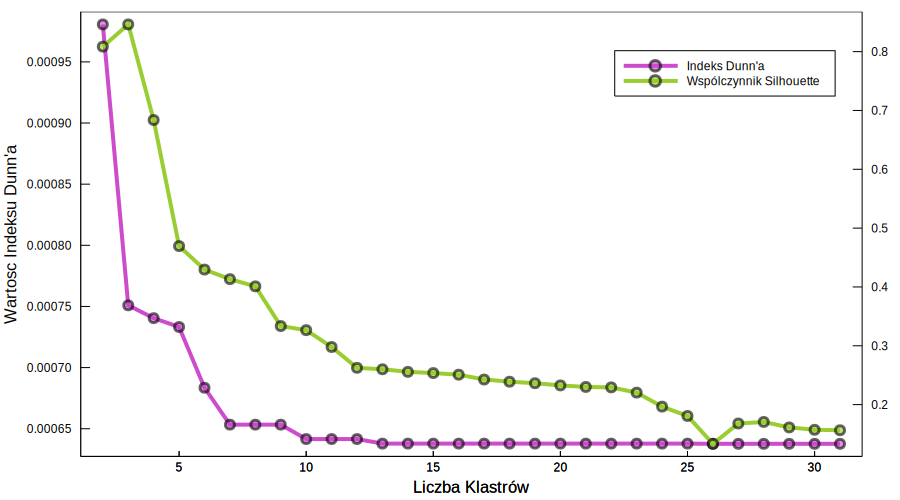

In [11]:
p = plot(2:n,stats[1,:][2:n], legend=false, label = "Indeks Dunn'a", lw = 4, xlabel = "Liczba Klastrów",
    ylabel = "Wartosc Indeksu Dunn'a ",
    color=:lightrainbow, marker = (:circle, 5, 0.6, :match, stroke(3, 0.2, :black, :dot)),size = (900, 500),grid = :off)
p = plot!(2:n,NaN.*(2:n),color=:yellowgreen,legend=:topright, label = "Wspólczynnik Silhouette",lw = 4,
    marker = (:circle, 5, 0.6, :match, stroke(3, 0.2, :black, :dot)),size = (900, 500))
p = plot!(twinx(),2:n,stats[2,:][2:n], legend=false, label = "Wspólczynnik Silhouette", lw = 4,grid = :off,box = :on,
    xlabel = "Liczba Klastrów",ylabel = "Wartosc Wspólczynnika Silhouette",
    color=:yellowgreen, marker = (:circle, 5, 0.6, :match, stroke(3, 0.2, :black, :dot)),size = (900, 500))
IJulia.clear_output();p

# Porówananie Algorytmów

Jednen z algorytmów w większości przypadków dzieli zbiór danych na dwa klastry.
Drugi natomiast przyjmuje najwyższe wyniki metryk kiedy to dzielimy zbiór na 2 klastry.
Oba algorytmy dają podobny wynik.
Sprawdzmy teraz który z nich osiąga lepsze metryki dla dwóch klastrów.

In [70]:
print("Wspólczynnik Silhouette | Algorytm Hierarchicznyy: ",mean(silhouettes(d_mar.assignments,d_mat)))
println(" Algorytm MCL: ",stats[2,2] )

Wspólczynnik Silhouette | Algorytm Hierarchicznyy: 0.8085010364583612 Algorytm MCL: 0.8085010364583612


In [71]:
print("Indeks Dunn'a | Algorytm Hierarchiczny: ",dunn_index(d_mat,d_mar.assignments,data))
println(" Algorytm MCL: ",stats[1,2] )

Indeks Dunn'a | Algorytm Hierarchiczny: 0.0009806564486071329 Algorytm MCL: 0.0009806564486071329


Algorytmy mają te same wartości metryk. 

In [14]:
mean(d_mar.assignments == cutree(d_hcl,k=2) )

0.0

# Wizualizacja Klasteryzacji

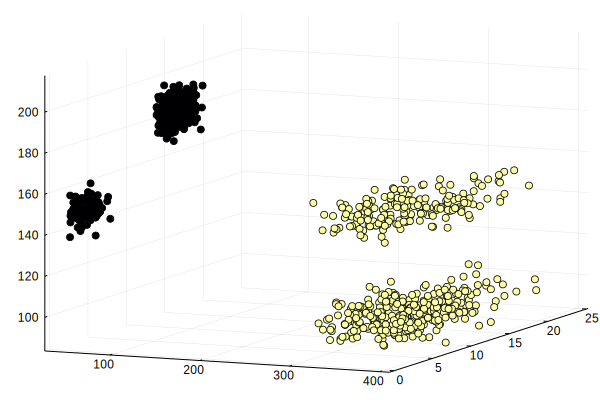

In [15]:
scatter(data[:,1],data[:,3],data[:,2],marker_z = cutree(d_hcl,k=2) , legend = false,)

Jak widać na powyższym wykresie nie udało mi się przeprowadzić poprawnej klasteryzacji.
Algorytm hierarchiczny dla 4 klastrów faktycznie poprawnie klasteryzuje punkty to jednak algorytm MCL nie działa pomimo testowania wielu parametrów.

Poprawna klasteryzacja zaprezentowana poniżej.

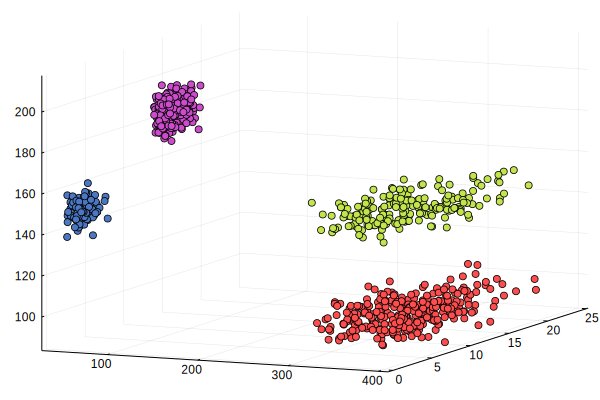

In [16]:
scatter(data[:,1],data[:,3],data[:,2],marker_z = cutree(d_hcl,k=4) , legend = false, color=:lightrainbow)

Obie metryki nie wskazały w znaczący sposób aby akurat wartość k = 4 była odpowiednia. 

W przykładach poniżej widać wizualizacje dla k = 5 oraz k = 10.
Widać pojedyncze punkty jako jedyne zaliczone do poszczególnych klastrów.

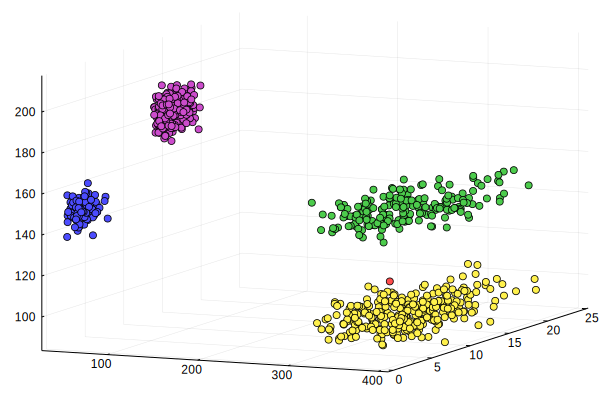

In [17]:
scatter(data[:,1],data[:,3],data[:,2],marker_z = cutree(d_hcl,k=5) , legend = false, color=:lightrainbow)

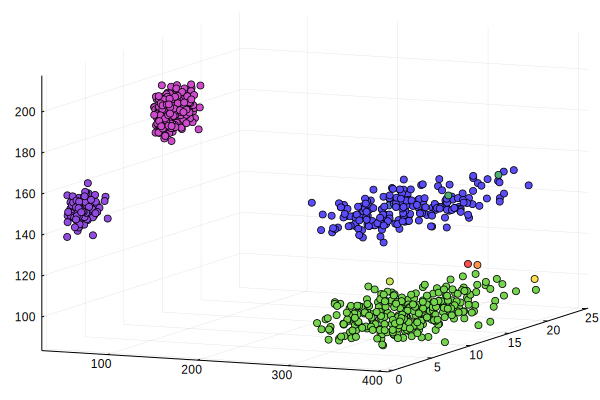

In [18]:
scatter(data[:,1],data[:,3],data[:,2],marker_z = cutree(d_hcl,k=10) , legend = false, color=:lightrainbow)

# Podsumowanie

"Pewność co do wyniku algorytmu MCL mocno mmnie zdziwiła.
Po ponownym preszukaniu internetu nie znalazłem żadnego sposobu na porawienie moich wyników.
Oczywistym jest że metoda hierarchiczna okazała się lepsza.

<div style="text-align: right"> <b>Marcin Łukaszyk Grupa 2 </b> </div>